# Section - About Code

In [ ]:
# Section - CoLab Description

# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Author - shankyram@

# Contributor Attribution
# This code uses prompts designed by kkrish
# Thanks to PSO team members gopalad dsharmila for pointing me to open cv, rembg libraries

# Last Updated On - 31 Oct 2024

# Solution to demonstrate a banner generation pipeline with
## Imagen3 for actor asset creation
## Python & Gradio frontend to
##    * Imagen3 generated actor assets for target segments
##    * Pipeline action to remove actor asset background for overlay placement
##    * UI for design banner layout & multi text or image design placement
##    * UI for campaign definition for auto banner creation
## Leveraging libraries like pillow, cv2, rembg, SAM & Imagen models

## Introduction
# This demo showcases a cutting-edge solution for hyper-personalized banner generation, designed to revolutionize your telecom Customer Value Management (CVM) strategies. By leveraging AI and a dynamic approach, we can create highly targeted and engaging banners that resonate with individual customer segments, driving conversions and enhancing brand loyalty.
# The Problem: Traditional banner campaigns often rely on generic messaging and visuals, resulting in low engagement and limited impact. Customers are bombarded with irrelevant ads, leading to banner blindness and missed opportunities.
# Our Solution: This innovative platform utilizes AI-powered image generation and dynamic banner assembly to create hyper-personalized experiences. Imagine banners that feature:
# Contexual faces: Actors that reflect the age, ethnicity, and lifestyle of specific customer segments.
# Personalized offers: Product recommendations and promotions tailored to individual needs and preferences.
# Dynamic backgrounds: Visually appealing scenes that resonate with customer interests and demographics.

## Setup Instructions

# 1. Create two GCS bucket following
  # this format - “<Project Number>_telecom_demo_artefacts_bannergen_input
  # this format - “<Project Number>_telecom_demo_artefacts_bannergen_runtime
  # In the above example this is - 554686566379_telecom_demo_artefacts_bannergen_input

  # Down the entire “Artefacts” and
  # upload them into the “ bucket
  # Take note to upload the entire “Artefacts” folder as shown below

# 2. Create a new Firestore instance “banner-gen-app” in Native mode with Database ID “banner-gen-app”

# 3. If you need to update new banner templates, or logos etc, update into the bucket directory "*telecom_demo_artefacts_bannergen_input - /Logo" or /Background or /Actors (to bring your own talent images)"
# 4. Please ensure there is nothing uploaded in "_telecom_demo_artefacts_bannergen_input/Background_Processed" since this will automatically be done in notebook code
# 5. If you add new assets into "_telecom_demo_artefacts_bannergen_input" in "Actors" / "Background", "Graphics", "Logo", ensure that you rerun the colab from Section - Demo Configuration & Initialization
# 6. The contents of "_telecom_demo_artefacts_bannergen_input/Config" are for bootstrapping only and subsequently are updated into the firebase DB

# 7. Note that all output images generated are temporarily retained in colab local dir and will NOT be saved on colab termination. If you want to reuse them, download them from the folder /content/demo/output for future reference.

## Execution Instructions

# Step 1: Demo Asset Library
# Explore the building blocks of dynamic banners, including a diverse library of actors, backgrounds, logos, graphics, and text elements.
# Remember to click on the check box in file explorer not the arrow since the UX components seem to have a better experience with checkbox

# Step 2: Demo Asset Creation
# Witness the creation of new visual segments aligned with your specific customer targeting needs.
# See how AI-powered image generation (Imagen3) can be used to create realistic and diverse actors.
# Remember to save the images to the library for the visual segment to be saved in database and images to be available for banner generation

# Step 3: Demo Asset Preprocessing
# Understand the importance of background removal for seamless integration of actors and elements onto banner templates.
# Remember to preprocess newly created visual assets for removing background
# Remember logos and graphic elements are expected to be already having transparent background

# Step 4: Demo Banner Template Configuration
# Learn how banner templates can be defined using intuitive UX providing flexibility and creative control.
# Remember that this is configuration controlling placement of text and images in output. Use the tool selection options to define where text header / body and various graphic elements need to be placed

# Step 5: Demo Banner Generation
# Experience the magic of dynamic banner generation, where personalized banners are automatically created for multiple templates and visual segments.
# Remember to click on refresh visual segment to reload the dropdown for reflecting new visual segments

## Code Updates
# 31 Oct 2024
#  - Added fix to support new banner templates to be loaded via upload to GCS bucket (see setup instruction 3 above)
#  - Added fix to refresh visual segment
#  - Added fix to leave some of image / text inputs in banner generation empty

# Section - Code (Global Pre-req - Installs)



In [ ]:
# @title Authenticate Profile

# Authentication with Google Account
from google.colab import auth as google_auth_profile
google_auth_profile.authenticate_user()

In [ ]:
# @title Install Required Libraries

print ('\nINFO. Installing required libraries.\n')


# Langchain & other libraries
!pip install IPython

!pip install opencv-python
!pip install Pillow
!pip install rembg
!pip install matplotlib
!pip install pyfonts
# !pip install torch torchvision segment-anything

!pip install gradio_image_annotation
!pip install --upgrade gradio "gradio<5.0,>=4.29"
!pip install gradio_image_annotation

!pip install --upgrade --user --quiet google-cloud-aiplatform

print ('\nINFO. Installed all libraries. RESTARTING runtime.\n')

# Automatically restart runtime post library imports
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)


INFO. Installing required libraries.

  Using cached gradio-5.4.0-py3-none-any.whl (56.7 MB)

INFO. Installed all libraries. RESTARTING runtime.



{'status': 'ok', 'restart': True}

In [ ]:
# @title Import Required Global Packages

# General Colab Packages
from google.colab import drive
from google.colab import files
import shutil

# General OS Packages
import os
import io
import json
import numpy as np
import shutil
import pandas as pd
from os.path import splitext
from typing import List, Sequence
from PIL import Image, UnidentifiedImageError
import numpy as np
import base64
import datetime
import time

import gradio as gr

# Google Cloud / API Imports
from google.cloud import storage
from google.cloud import resourcemanager_v3
from google.api_core.exceptions import NotFound

# Vertex AI Imports
import vertexai
import requests
from vertexai.generative_models import (
    Content,
    FunctionDeclaration,
    GenerationConfig,
    GenerativeModel,
    Part,
    Tool,
)

# @title Import Required Global Packages

# General Colab Packages
from google.colab import drive
from google.colab import files

In [ ]:
# @title Initializate Project configuration

# Google Cloud Project
PROJECT_ID = "genai-e2e-demos" # @param {type:"string"}
PROJECT_LOCATION = "us-central1" # @param {type:"string"}
GCS_LOCATION = "US" # @param {type:"string"}

# Create a client
client = resourcemanager_v3.ProjectsClient()
# Get the project ID from the project name
project_name = f"projects/{PROJECT_ID}"  # Change this to your project ID
# Make the request
response = client.get_project(name=project_name)

# Retrieve PROJECT_NUMBER value
PROJECT_NUMBER = client.get_project(name=project_name).name.split("/")[-1]

print(f"Connecting to Google Cloud Project ID: {PROJECT_ID} with Project Number: {PROJECT_NUMBER} in location: {PROJECT_LOCATION}")

Connecting to Google Cloud Project ID: genai-e2e-demos with Project Number: 554686566379 in location: us-central1


# Section - Code (Global Pre-req - Imports / Initialization)

In [ ]:
# @title Initializate Vertex AI Client

# Initialization - ADC Not necessary since we already logged into Colab

# credentials = service_account.Credentials.from_service_account_file(SVC_KEY_PATH)
# OR
# !gcloud auth application-default login
# !gcloud auth application-default set-quota-project $PROJECT_ID

# Initialization - Vertex AI
vertexai.init(project=PROJECT_ID, location=PROJECT_LOCATION)

# Section - Utility Functions

In [ ]:
# @title Utility - Assorted General GCS Related

def list_files_in_gcs_bucket(bucket_name, project_id):
    """Lists all the blobs in the bucket."""
    storage_client = storage.Client(project=project_id)
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs()  # Get all blobs
    return [blob.name for blob in blobs]  # Extract filenames

def list_files_in_gcs_bucket_folder(bucket_name, folder, project_id):
    """Lists all the files within a specified folder in the bucket."""
    storage_client = storage.Client(project=project_id)
    bucket = storage_client.bucket(bucket_name)

    # Use the prefix parameter to filter blobs within the folder
    blobs = bucket.list_blobs(prefix=folder)

    return [blob.name for blob in blobs]

def download_to_local_folder_from_gcs_bucket(bucket_name, file_name, local_folder_path, project_id):
  """Downloads a blob from GCS and saves it locally"""
  storage_client = storage.Client(project=project_id)

  bucket = storage_client.bucket(bucket_name)
  blob = bucket.blob(file_name)

  try:
      # Check if blob exists before downloading
      if blob.exists():
        # Create destination directory if it doesn't exist
          # Extract the GCS folder structure from the file name
          gcs_folder_path = os.path.dirname(file_name)

          # Combine the local folder path with the GCS folder structure
          full_local_path = os.path.join(local_folder_path, gcs_folder_path)

          # Create the full local directory structure if it doesn't exist
          os.makedirs(full_local_path, exist_ok=True)

          dst_file_path = os.path.join(full_local_path, os.path.basename(file_name))

          blob.download_to_filename(dst_file_path)
          print(f"Downloaded {file_name} to {full_local_path}")
      else:
          print(f"Blob {file_name} does not exist in bucket {bucket_name}")
  except Exception as e:
      print(f"An error occurred: {e}")

def download_to_local_folder_from_gcs_folder(bucket_name, file_name, local_folder_path, project_id):

  """Downloads a blob from GCS and saves it locally"""
  storage_client = storage.Client(project=project_id)

  bucket = storage_client.bucket(bucket_name)
  blob = bucket.blob(file_name)

  try:
      # Check if blob exists before downloading
      if blob.exists():
          # Create destination directory if it doesn't exist
          destination_directory = os.path.dirname(local_folder_path)
          os.makedirs(destination_directory, exist_ok=True)

          dst_file_path = os.path.join(local_folder_path, os.path.basename(file_name))
          blob.download_to_filename(dst_file_path)
          print(f"Downloaded {file_name} to {local_folder_path}")
      else:
          print(f"Blob {file_name} does not exist in bucket {bucket_name}")
  except Exception as e:
      print(f"An error occurred: {e}")

def copy_file_to_gcs(localfilepath, gcs_bucket_name, gcs_folder, gcs_filename, project_id):
    """Copies a local file to Google Cloud Storage."""

    try:
        # Check if the file exists
        if not os.path.exists(localfilepath):
            raise FileNotFoundError(f"File not found: {localfilepath}")

        # Upload to Google Cloud Storage
        storage_client = storage.Client(project=project_id)
        bucket = storage_client.bucket(gcs_bucket_name)

        # Create the bucket if it doesn't exist
        if not bucket.exists():
            bucket = storage_client.create_bucket(gcs_bucket_name)

        blob_name = os.path.join(gcs_folder, gcs_filename)
        blob = bucket.blob(blob_name)

        # Upload the local file, overwriting if it exists
        blob.upload_from_filename(localfilepath)

        print(
            f"File {localfilepath} uploaded to gs://{gcs_bucket_name}/{blob_name}"
        )

    except (FileNotFoundError, ValueError, Exception) as e:  # Use PyPDF2.utils.PdfReadError
        print(f"Error: {e}")

def delete_bucket_and_contents(bucket_name, project_id):
    """Deletes a GCS bucket and all its contents."""

    storage_client = storage.Client(project=project_id)

    try:
        # Get the bucket object
        bucket = storage_client.get_bucket(bucket_name)

        # Delete all blobs (objects) in the bucket
        blobs = bucket.list_blobs()
        for blob in blobs:
            blob.delete()
        print(f"Deleted all objects in bucket {bucket_name}")

        # Delete the bucket itself
        bucket.delete()
        print(f"Deleted bucket {bucket_name}")

    except NotFound:
        print(f"Bucket {bucket_name} not found, ignoring.")

def delete_bucket_contents(bucket_name, project_id):
    """Deletes all contents in GCS bucket."""

    storage_client = storage.Client(project=project_id)

    try:
        # Get the bucket object
        bucket = storage_client.get_bucket(bucket_name)

        # Delete all blobs (objects) in the bucket
        blobs = bucket.list_blobs()
        for blob in blobs:
            blob.delete()
        print(f"Deleted all objects in bucket {bucket_name}")

    except NotFound:
        print(f"Bucket {bucket_name} not found, ignoring.")

def create_bucket_if_not_exists(bucket_name, project_id, location=GCS_LOCATION):
    """Creates a GCS bucket if it doesn't already exist. """

    storage_client = storage.Client(project=project_id)

    try:
        bucket = storage_client.get_bucket(bucket_name)
        print(f"Bucket {bucket_name} already exists.")  # Bucket found
    except:  # Bucket not found, so create it
        bucket = storage_client.bucket(bucket_name)
        bucket.storage_class = "STANDARD"
        new_bucket = storage_client.create_bucket(bucket, location=location)
        print(f"Created bucket {new_bucket.name} in {new_bucket.location}.")

In [ ]:
# @title Utility - Folder / File Mgmt. Functions

def list_files_in_folder(folder_path, folder_name=''):
  file_list = []
  for item in os.listdir(folder_path):
      item_path = os.path.join(folder_path, item)
      if os.path.isfile(item_path):
          file_list.append(os.path.join(folder_name, item))
      elif os.path.isdir(item_path):
          file_list.extend(list_files_in_folder(item_path, os.path.join(folder_name, item)))
  return file_list

def download_to_computer(folder_path, file_name):
  file_path = os.path.join(folder_path, file_name)

  if os.path.exists(file_path):  # Check if the file exists
      files.download(file_path)  # Download to the local computer
      print(f"Downloaded '{file_name}'")
  else:
      print(f"File not found: '{file_name}'")

def download_to_local_folder(src_folder_path, file_name, local_folder_path):
  src_file_path = os.path.join(src_folder_path, file_name)
  dst_file_path = os.path.join(local_folder_path, file_name)

  if os.path.exists(src_file_path):  # Check if the file exists

      # Copy the file from Google Drive
      shutil.copy(src_file_path, dst_file_path)
      print(f"Copied '{file_name}' to {dst_file_path}")
  else:
      print(f"File not found: '{file_name}'")

def copy_with_subfolders(src, dst):

  if not os.path.exists(dst):
    os.makedirs(dst)  # Create the destination directory if it doesn't exist

  for item in os.listdir(src):
    src_element = os.path.join(src, item)
    dst_element = os.path.join(dst, item)
    if os.path.isdir(src_element):
      shutil.copytree(src_element, dst_element)
  # Recursively copy subdirectories
    else:
      shutil.copy2(src_element, dst_element)  # Copy files

def delete_all_files(directory):

  for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    try:
      if os.path.isfile(file_path):
        os.remove(file_path)

        print(f"Deleted: {file_path}")
    except Exception as e:
      print(f"Error deleting {file_path}: {e}")

def get_filenames_in_folder(path):

  filenames = []
  for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isfile(item_path):
      filenames.append(item)
  return filenames

def get_filepath_in_folder_nested(path):
  filenames = []
  for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isfile(item_path):
      filenames.append(item_path)  # Append the full path
    elif os.path.isdir(item_path):
      filenames.extend(get_filepath_in_folder_nested(item_path))  # Recursive call
  return filenames

def find_files_with_prefix(directory, prefix):
  matching_files = []
  for root, _, files in os.walk(directory):
    for file in files:
      if file.startswith(prefix):
        matching_files.append(os.path.join(root, file))
  return matching_files

def create_file_map(folder_path, extension, prefix):
  file_map = {}
  for filename in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, filename)):
      base_name, file_extension = os.path.splitext(filename)

      if file_extension.lower() == extension.lower():  # Case-insensitive comparison
        absolute_path = os.path.abspath(os.path.join(folder_path, filename))
        file_map[base_name.removeprefix(prefix)] = absolute_path

  return file_map

In [ ]:
# @title Utility - Assorted JSON Handling for Gradio

def json_to_html_table(json_data):
    try:
        data_dict = json.loads(json_data)
    except json.JSONDecodeError:
        return "<p>Invalid JSON format.</p>"

    html_table = """
    <table border="1">
        <tr>
            <th>Attribute</th>
            <th>Value</th>
        </tr>
    """

    for key, value in data_dict.items():
        html_table += f"<tr><td>{key}</td><td>{value}</td></tr>"

    html_table += "</table>"
    return html_table

In [ ]:
# @title Utility - Imagen3 & Gemini Model Invocations

import vertexai
from vertexai.preview.vision_models import ImageGenerationModel

def generate_imagen_outputs(prompt, number_of_images, aspect_ratio, model="imagen-3.0-generate-001"):
  print(f"Input - No. of Images : {number_of_images}, Aspect Ratio {aspect_ratio}, Model {model}, Prompt - \n {prompt}")
  generation_model = ImageGenerationModel.from_pretrained(model)
  image_list = generation_model.generate_images(
      prompt=prompt,
      number_of_images=number_of_images,
      aspect_ratio=aspect_ratio,
  )
  print(f"Generated {len(image_list.images)} images for prompt with model {model}")
  return image_list.images

# Usage
# import io
# import base64
# from PIL import Image
# import matplotlib.pyplot as plt

# prompt_x = f"""
#   "Subject: a young Indonesian woman"
#   "Age: 20-30 years old"
#   "Clothing: Modern stylish clothing in red / yellow"
#   "Theme: Joyfully looking at her phone"
#   "Environment Settings: white bacjground"
#   "Photography Setting: studio lighting, DLSR"
# """

# image_list = generate_imagen_outputs(prompt_x, 1, "4:3")

# processed_images = []
# for generated_image in image_list:
#     print(f"In generated_image")
#     generated_image_data = base64.b64decode(generated_image._as_base64_string())
#     pil_image = Image.open(io.BytesIO(generated_image_data))

#     # Display the image
#     pil_image.show()

#     # Display with matplotlib
#     plt.imshow(pil_image)
#     plt.axis('off')  # Hide axes
#     plt.show()

def invoke_gemini_multimodal_model_with_files(model: GenerativeModel, contents: list[Content]):
  response = model.generate_content(contents)
  return (response)

def invoke_gemini_for_text(prompt, model_input="gemini-1.5-pro-001"):
  model = GenerativeModel(model_input)
  response = model.generate_content(prompt)
  return response.text

# Section - Demo Configuration & Initialization

In [ ]:
# @title Demo Notebook Configuration Step 1A - Create local folders for input and output, initialize asset library

LOCAL_INPUT_DIR = "/content/demo/input"
LOCAL_INPUT_DIR_ARTEFACTS = f"{LOCAL_INPUT_DIR}/Artefacts"
LOCAL_INPUT_DIR_ACTOR = f"{LOCAL_INPUT_DIR_ARTEFACTS}/Actors"
LOCAL_INPUT_DIR_BG = f"{LOCAL_INPUT_DIR_ARTEFACTS}/Background"
LOCAL_INPUT_DIR_LOGO = f"{LOCAL_INPUT_DIR_ARTEFACTS}/Logo"
LOCAL_INPUT_DIR_GRAPHICS = f"{LOCAL_INPUT_DIR_ARTEFACTS}/Graphics"
LOCAL_INPUT_DIR_CONFIG = f"{LOCAL_INPUT_DIR_ARTEFACTS}/Config"

LOCAL_TEMP_DIR = "/content/demo/temp"

LOCAL_OUTPUT_DIR = "/content/demo/output"
LOCAL_OUTPUT_DIR_ACTOR = "/content/demo/output/Actors_Processed"
LOCAL_OUTPUT_DIR_BG = "/content/demo/output/Background_Processed"
LOCAL_OUTPUT_DIR_BANNER = "/content/demo/output/Banner_Processed"

# Demo Configuration Attributes
democonfig_artefacts_required = [
    "Artefacts/Config/config.json"
]

# Delete existing contents and reset
if os.path.exists(LOCAL_INPUT_DIR):
    shutil.rmtree(LOCAL_INPUT_DIR)  # Delete the existing directory and its contents

if os.path.exists(LOCAL_TEMP_DIR):
    shutil.rmtree(LOCAL_TEMP_DIR)  # Delete the existing directory and its contents

if os.path.exists(LOCAL_OUTPUT_DIR):
    shutil.rmtree(LOCAL_OUTPUT_DIR)  # Delete the existing directory and its contents

os.makedirs(LOCAL_INPUT_DIR)  # Recreate the directory
os.makedirs(LOCAL_INPUT_DIR_ACTOR)  # Recreate the directory
os.makedirs(LOCAL_INPUT_DIR_BG)  # Recreate the directory
os.makedirs(LOCAL_INPUT_DIR_LOGO)  # Recreate the directory
os.makedirs(LOCAL_INPUT_DIR_GRAPHICS)  # Recreate the directory
os.makedirs(LOCAL_INPUT_DIR_CONFIG)  # Recreate the directory

os.makedirs(LOCAL_TEMP_DIR)  # Recreate the directory

os.makedirs(LOCAL_OUTPUT_DIR)  # Recreate the directory
# os.makedirs(LOCAL_OUTPUT_DIR_ACTOR)  # Recreate the directory
# os.makedirs(LOCAL_OUTPUT_DIR_BG)  # Recreate the directory
os.makedirs(LOCAL_OUTPUT_DIR_BANNER)  # Recreate the directory

# # Configure initialize path for input and temp outputs
# BANNER_INPUT_DRIVE_SRC = 'Colab Notebooks/IOH-BannerGen/Artefacts' # @param {type:"string"}
# banner_input_drive_path = os.path.join(DRIVE_HOME, BANNER_INPUT_DRIVE_SRC)

# # Copy files from Google Drive to the local directory
# copy_with_subfolders(banner_input_drive_path, LOCAL_INPUT_DIR)

# # Demo GCS Defaults
demo_input_gcs_bucket_root ="telecom_demo_artefacts_bannergen_input"
demo_input_gcs_bucket = f"{PROJECT_NUMBER}_{demo_input_gcs_bucket_root}"
demo_input_gcs_bucket_config = f"{PROJECT_NUMBER}_{demo_input_gcs_bucket}/Artefacts/Config"
print (f"Loading configuration from gs://{demo_input_gcs_bucket}")

demo_runtime_gcs_bucket_root ="telecom_demo_artefacts_bannergen_runtime"
demo_runtime_gcs_bucket = f"{PROJECT_NUMBER}_{demo_runtime_gcs_bucket_root}"
demo_runtime_gcs_bucket_temp = f"{PROJECT_NUMBER}_{demo_runtime_gcs_bucket_root}_temp"
demo_runtime_gcs_bucket_output = f"{PROJECT_NUMBER}_{demo_runtime_gcs_bucket_root}_output"

# Clean up GCS Buckets
create_bucket_if_not_exists(demo_input_gcs_bucket, PROJECT_ID)

print(f"\nRebuilding notebook GCP bucket(s) holding temp files from scratch.")
create_bucket_if_not_exists(demo_runtime_gcs_bucket, PROJECT_ID)
delete_bucket_contents(demo_runtime_gcs_bucket, PROJECT_ID)

# Get list of files in the initialize location
existing_files = list_files_in_gcs_bucket(f"{demo_input_gcs_bucket}", PROJECT_ID)

# Categorize files
required_and_found = [mandatoryfile for mandatoryfile in democonfig_artefacts_required if mandatoryfile in existing_files]
required_but_not_found = [mandatoryfile for mandatoryfile in democonfig_artefacts_required if mandatoryfile not in existing_files]

# Print summaries
print(f"\nRequired demo config files found ({len(required_and_found)}):")
for file in required_and_found:
    print(f"- {file}")

print(f"\nRequired files demo config files not found ({len(required_but_not_found)}):")
for file in required_but_not_found:
    print(f"- {file}")

# Check initialization status and raise exception if needed
if required_but_not_found:
    missing_files_str = ", ".join(required_but_not_found)
    print("\nDemo initialization status: Failed")
    raise FileNotFoundError(f"Mandatory config files not found in {democonfig_artefacts_required}")
else:
    print(f"\nDownloading Demo Artefacts from GCS bucket - {democonfig_artefacts_required}")
    # Download each required demo artefacts files from central location
    for file_name in existing_files:
      download_to_local_folder_from_gcs_bucket(demo_input_gcs_bucket, file_name, LOCAL_INPUT_DIR, PROJECT_ID)

    # Move relevant folders to output directory
    shutil.move(f"{LOCAL_INPUT_DIR_ARTEFACTS}/Actors_Processed", LOCAL_OUTPUT_DIR)
    shutil.move(f"{LOCAL_INPUT_DIR_ARTEFACTS}/Background_Processed", LOCAL_OUTPUT_DIR)

    print("\nDemo initialization status: Successful")

Loading configuration from gs://554686566379_telecom_demo_artefacts_bannergen_input
Bucket 554686566379_telecom_demo_artefacts_bannergen_input already exists.

Rebuilding notebook GCP bucket(s) holding temp files from scratch.
Bucket 554686566379_telecom_demo_artefacts_bannergen_runtime already exists.
Deleted all objects in bucket 554686566379_telecom_demo_artefacts_bannergen_runtime

Required demo config files found (1):
- Artefacts/Config/config.json

Required files demo config files not found (0):

Downloaded Artefacts/Actors/Old_Woman_Individual/Old_Woman_Individual_1.png to /content/demo/input/Artefacts/Actors/Old_Woman_Individual
Downloaded Artefacts/Actors/Old_Woman_Individual/Old_Woman_Individual_2.png to /content/demo/input/Artefacts/Actors/Old_Woman_Individual
Downloaded Artefacts/Actors/Old_Woman_Individual/Old_Woman_Individual_3.png to /content/demo/input/Artefacts/Actors/Old_Woman_Individual
Downloaded Artefacts/Actors/Young_Digital_Duo/Young_Digital_Duo_1.png to /content

In [ ]:
# @title Demo Notebook Configuration Step 1B - Reinitialize firebase, instance banner-gen-app should be pre-created

flag_reinitialize_firebase = False #@param {type:"boolean"}

from google.cloud import firestore

FIRESTORE_INSTANCE_ID = "banner-gen-app"

# Initialize Firestore Client (replace with your project ID and database ID)
db = firestore.Client(project=PROJECT_ID, database=FIRESTORE_INSTANCE_ID)

# Get a reference to the collection
collection_visuals_segment_clusters = db.collection('visuals_segment_clusters')

def init_visual_segment():
  # Path to config.json file
  config_file_path = LOCAL_INPUT_DIR_CONFIG + "/config.json"

  try:
    with open(config_file_path, 'r') as f:
      config_data = json.load(f)

    # Extract the visuals_segment_clusters array
    visual_segments = config_data.get('visuals_segment_clusters', [])

    # Get a reference to the collection
    collection_ref = db.collection('visuals_segment_clusters')

    # Add each visual segment to the collection
    for segment in visual_segments:
      # Use the 'visualsegment' value as the document ID
      doc_ref = collection_ref.document(segment['visualsegment'])
      doc_ref.set(segment)

    print("Visual segments configuration added to Firestore successfully!")

  except FileNotFoundError:
    print(f"Error: Config file not found at {config_file_path}")
  except Exception as e:
    print(f"An error occurred: {e}")

def init_banner_template():
  # Path to config.json file
  config_file_path = LOCAL_INPUT_DIR_CONFIG + "/config.json"

  try:
    with open(config_file_path, 'r') as f:
      config_data = json.load(f)

    # Extract the banner_template array
    banner_template = config_data.get('banner_template', [])

    # Get a reference to the collection
    collection_ref = db.collection('banner_template')

    # Add each visual segment to the collection
    for banner in banner_template:
      # Use the 'bannertemplate' value as the document ID
      doc_ref = collection_ref.document(banner['bannertemplate'])
      doc_ref.set(banner)

    print("Banner template configuration added to Firestore successfully!")

  except FileNotFoundError:
    print(f"Error: Config file not found at {config_file_path}")
  except Exception as e:
    print(f"An error occurred: {e}")

# Check if the collection exists
if collection_visuals_segment_clusters.get():
  if(flag_reinitialize_firebase):
    print("Collection visuals_segment_clusters exists. Deleting...")

    # Delete all documents in the collection
    docs = collection_visuals_segment_clusters.stream()
    for doc in docs:
      doc.reference.delete()

    print("Collection visuals_segment_clusters deleted successfully!")
    init_visual_segment()

  else:
    print("Skipping firebase visuals_segment_clusters config recreation since flag_reinitialize_firebase is set to TRUE.")
else:
  print("Collection visuals_segment_clusters does not exist.")
  init_visual_segment()

# Get a reference to the collection
collection_banner_template = db.collection('banner_template')

# Check if the collection exists
if collection_banner_template.get():
  if(flag_reinitialize_firebase):
    print("Collection banner_template exists. Deleting...")

    # Delete all documents in the collection
    docs = collection_banner_template.stream()
    for doc in docs:
      doc.reference.delete()

    print("Collection banner_template deleted successfully!")
    init_banner_template()
  else:
    print("Skipping firebase banner_template config recreation since flag_reinitialize_firebase is set to TRUE.")
else:
  print("Collection banner_template does not exist.")
  init_banner_template()

Skipping firebase visuals_segment_clusters config recreation since flag_reinitialize_firebase is set to TRUE.
Skipping firebase banner_template config recreation since flag_reinitialize_firebase is set to TRUE.


# Section - Main Business Logic

In [ ]:
# @title Demo Notebook Configuration Step 2A - Firestore Functions

def get_visual_segments_from_db():

  try:
    collection_ref = collection_visuals_segment_clusters
    docs = collection_ref.stream()

    visual_segments = []
    for doc in docs:
        visual_segments.append(doc.to_dict())

    return visual_segments

  except Exception as e:
    print(f"An error occurred while retrieving visual segments: {e}")
    return []  # Return an empty list in case of an error

def get_visual_segments_list():
    return [segment['visualsegment'] for segment in get_visual_segments_from_db()]

def get_visual_segments_config(visual_segment_name):
    for segment in get_visual_segments_from_db():
      if segment['visualsegment'] == visual_segment_name:
        return segment

def add_or_update_visual_segment(segment_data):
  try:
      visual_segment_key = segment_data['visualsegment']
      doc_ref = collection_visuals_segment_clusters.document(visual_segment_key)

      if doc_ref.get().exists:
          # Update the existing document
          doc_ref.update(segment_data)
          print(f"Visual segment '{visual_segment_key}' updated successfully.")
          return "updated"
      else:
          # Create a new document
          doc_ref.set(segment_data)
          print(f"Visual segment '{visual_segment_key}' created successfully.")
          return "created"

  except Exception as e:
      error_message = f"An error occurred: {e}"
      print(error_message)
      return error_message

def add_or_update_bannertemplate(template_data):
  try:
      banner_template_key = template_data['bannertemplate']
      doc_ref = collection_banner_template.document(banner_template_key)

      if doc_ref.get().exists:
          # Update the existing document
          doc_ref.update(template_data)
          print(f"Banner template '{banner_template_key}' updated successfully.")
          return "updated"
      else:
          # Create a new document
          doc_ref.set(template_data)
          print(f"Banner template '{banner_template_key}' created successfully.")
          return "created"

  except Exception as e:
      error_message = f"An error occurred: {e}"
      print(error_message)
      return error_message

def get_bannertemplate_from_db():

  try:
    collection_ref = collection_banner_template
    docs = collection_ref.stream()

    banner_template = []
    for doc in docs:
        banner_template.append(doc.to_dict())

    return banner_template

  except Exception as e:
    print(f"An error occurred while retrieving visual segments: {e}")
    return []  # Return an empty list in case of an error

def get_bannertemplate_list():
    return [template['bannertemplate'] for template in get_bannertemplate_from_db()]

def get_bannertemplate_config(bannertemplate):
    for template in get_bannertemplate_from_db():
      if template['bannertemplate'] == bannertemplate:
        return template

In [ ]:
# @title Main Business Logic Option 2B [Optimal] - Background removal with rembg and alpha_matting Masking + Binary Masked White space Removal

# delete_all_files(LOCAL_OUTPUT_DIR_ACTOR)

flag_execute_background_removal = False #@param {type:"boolean"}

from rembg import remove, new_session
from PIL import Image
import numpy as np
import io

def remove_background(input_path, output_path, mask_path, margin=10, alpha_threshold=10):
    # Open the input image
    with open(input_path, 'rb') as input_file:
        input_data = input_file.read()

    # Create a session with the u2net model (good for detecting objects)
    # <Shanky optimization comments> U2Net excels at accurate and detailed salient object detection, enabling high-quality background removal with preserved fine details and complex edge structures.
    session = new_session("u2net")

    # Remove the background
    # <Shanky code optimization comments> enables alpha matting for smoother edges. Alpha matting is a technique for determining partial transparency of pixels in an image, especially at object edges, to create smooth and realistic transitions between foreground and background.
    # <Shanky code optimization comments> alpha_matting_foreground_threshold high value (close to 255, which is pure white) is chosen because: a) It ensures that only pixels that are very likely to be part of the foreground are immediately classified as such (b) ensure that the solid parts of the  dress and the actor's skin are definitely classified as foreground
    # <Shanky code optimization comments> alpha_matting_background_threshold low value (close to 0, which is pure black) is chosen because: a) It ensures that only pixels that are very likely to be part of the background are immediately classified as such (b) we generate actor images with white background to optimize output, avoiding black or dark dress colors
    # <Shanky code optimization comments> alpha_matting_erode_size=10 parameter in rembg controls the size of the transition area between definite foreground and background for alpha matting. Useful for preserving details around actor dress and the hair or held objects, ensuring smooth transitions and preserved details.
    output_data = remove(input_data,
                         session=session,
                         alpha_matting=True,
                         alpha_matting_foreground_threshold=230,
                         alpha_matting_background_threshold=10,
                         alpha_matting_erode_size=10)

    # Open the output image and convert to numpy array
    output_image = Image.open(io.BytesIO(output_data)).convert("RGBA")
    output_array = np.array(output_image)

    # Extract the alpha channel
    alpha = output_array[:, :, 3]

    # Apply threshold to alpha channel for a binary mask filter
    # <Shanky code optimization comments> Using alpha_threshold to ensure excess white space in top or sides is removed. 2C had problem of excess white space in top
    alpha_threshold_mask = alpha > alpha_threshold

    # Find the bounding box of the non-transparent area
    rows = np.any(alpha_threshold_mask, axis=1)
    cols = np.any(alpha_threshold_mask, axis=0)

    if np.any(rows) and np.any(cols):  # Check if there's any content left after thresholding
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]

        # Add margin
        height, width = alpha.shape
        ymin = max(0, ymin - margin)
        ymax = min(height, ymax + margin)
        xmin = max(0, xmin - margin)
        xmax = min(width, xmax + margin)

        # Crop the image
        cropped_image = output_image.crop((xmin, ymin, xmax, ymax))

        # Save the cropped output image with transparent background
        cropped_image.save(output_path)

        # Crop and save the mask
        mask_image = Image.fromarray(alpha)
        cropped_mask = mask_image.crop((xmin, ymin, xmax, ymax))
        cropped_mask.save(mask_path)

        print(f"Background removed image saved to {output_path}")
        print(f"Mask saved to {mask_path}")
    else:
        print("No content found after applying threshold. Saving original image.")
        output_image.save(output_path)
        Image.fromarray(alpha).save(mask_path)

if(flag_execute_background_removal):

  list_input_files = get_filepath_in_folder_nested(os.path.join(LOCAL_INPUT_DIR_ARTEFACTS, "Actors"))

  for input_path in list_input_files:
    input_file = os.path.basename(input_path)
    output_path = os.path.join(LOCAL_OUTPUT_DIR_ACTOR, f"NoBg_{input_file}")
    mask_path = os.path.join(LOCAL_OUTPUT_DIR_ACTOR, f"Mask_{input_file}")
    remove_background(input_path, output_path, mask_path)

In [ ]:
# @title Main Business Logic 2C - Define Gridlines For Background Templates

flag_execute_bannertemplate_gridcreation = True #@param {type:"boolean"}

import cv2
import numpy as np

# <Shanky Comments> Below function was originally created for supporting automated boundary identification for backgrund and section. Retaining since manual grid is still useful with template config UI
def overlay_grid_with_coordinates(image_path, output_path, grid_size=50):

  input_image = cv2.imread(image_path)

  img_with_grid = input_image.copy()

  height, width = img_with_grid.shape[:2]

  # Primary Gridlines
  for x in range(0, width, grid_size):
      cv2.line(img_with_grid, (x, 0), (x, height), (0, 255, 0), 2)
  for y in range(0, height, grid_size):
      cv2.line(img_with_grid, (0, y), (width, y), (0, 255, 0), 2)

  # Secondary Gridlines (to support better grid selection)
  for x in range(50, width, grid_size):
      cv2.line(img_with_grid, (x, 0), (x, height), (255, 255, 255), 1)
  for y in range(50, height, grid_size):
      cv2.line(img_with_grid, (0, y), (width, y), (255, 255, 255), 1)

  for x in range(0, width, grid_size):
      for y in range(0, height, grid_size):
        # Put X and Y on separate lines with 10px spacing
        text_x = f"{x}"
        text_y = f"{y}"

        # Calculate text height to position Y label correctly
        (_, text_height), _ = cv2.getTextSize(text_x, cv2.FONT_HERSHEY_SIMPLEX + cv2.FONT_ITALIC, 0.8, 1)

        cv2.putText(img_with_grid, text_x, (x + 5, y + 25), cv2.FONT_HERSHEY_SIMPLEX + cv2.FONT_ITALIC, 0.8, (0, 0, 0), 1)
        cv2.putText(img_with_grid, text_y, (x + 5, y + 25 + text_height + 5), cv2.FONT_HERSHEY_SIMPLEX + cv2.FONT_ITALIC, 0.8, (0, 0, 0), 1)

  success = cv2.imwrite(output_path, img_with_grid)
  return success, height, width

# <Shanky Comments> Below function deprectated, no longer necessary to do automated boundary identification for section template since we are using manual boundary with UI
def find_section_template_in_bg(scene_path, template_path):
    # Read the images
    scene = cv2.imread(scene_path)
    template = cv2.imread(template_path)

    # Perform template matching to compare section to the background
    result = cv2.matchTemplate(scene, template, cv2.TM_CCOEFF_NORMED)

    # Find the best match
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Get the coordinates of the best match
    top_left = max_loc
    bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])

    return top_left

if(flag_execute_bannertemplate_gridcreation):

  list_input_files = get_filenames_in_folder(LOCAL_INPUT_DIR_BG)

  template_list = get_bannertemplate_list()

  for input_file in list_input_files:

    template = os.path.splitext(input_file)[0]

    if template in template_list:
        print(f"Template '{template}' exists.")
    else:
        print(f"Template '{template}' is new, Initializing configuration..")
        background_path = f"{LOCAL_INPUT_DIR_BG}/{input_file}"
        background_grid_path = f"{LOCAL_OUTPUT_DIR_BG}/Grid_{input_file}"
        opstatus, height, width = overlay_grid_with_coordinates(background_path, background_grid_path, 100)

        banner_config_data = {}
        banner_config_data["bannertemplate"] = f"{os.path.splitext(input_file)[0]}"
        banner_config_data["background_size"] = {"height": height, "width": width}

        add_or_update_bannertemplate(banner_config_data)

Template 'Template2' exists.
Template 'Template1' exists.
Template 'Template3' exists.


/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf
/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf
/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf
/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf
/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf
/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf
/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf
/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf
/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf
/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf
/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf
/usr/share/fonts/truetype/l

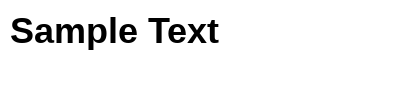

In [97]:
# @title Main Business Logic 2D - System Font Check

# Import the IPython display module
from IPython.display import display

from pyfonts import load_font
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# Print all available fonts and their paths after loading with PyFonts
import matplotlib.font_manager as fm

fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')
for font in fonts:
  print(font)

font = ImageFont.truetype("LiberationSans-Bold", 36) # Adjust size as needed
# Create a new image and draw the text
image = Image.new('RGB', (400, 100), color = (255, 255, 255))
draw = ImageDraw.Draw(image)
draw.text((10, 10), "Sample Text", font=font, fill=(0, 0, 0))
image.show()
output_path = "/content/demo/temp/output_font.png"
image.save(output_path)

# Use IPython.display to display the image
from IPython.display import Image
# Create an Image object and pass it to display
display(Image(filename=output_path))

In [98]:
# @title Main Business Logic 2E - Banner Generation Core Functions

import IPython.display as open_image
from PIL import Image, ImageDraw, ImageFont
from string import ascii_letters
import textwrap

def get_font_metrics(font):
    ascent, descent = font.getmetrics()
    avg_char_width = sum(font.getbbox(char)[2] for char in ascii_letters) / len(ascii_letters)
    return ascent, descent, avg_char_width

def wrap_text_custom(text, font, max_width):
    words = text.split()
    lines = []
    current_line = []
    current_width = 0

    for word in words:
        word_width = font.getbbox(word)[2]
        space_width = font.getbbox(' ')[2]

        if current_width + word_width <= max_width:
            current_line.append(word)
            current_width += word_width + space_width
        else:
            if current_line:
                lines.append(' '.join(current_line))
            current_line = [word]
            current_width = word_width + space_width

    if current_line:
        lines.append(' '.join(current_line))

    return lines

def get_font_size(textarea, text, font_name, pixel_gap=2):
    text_width, text_height = int(textarea[0]), int(textarea[1])

    for point_size in range(5, 300):
        font = ImageFont.truetype(font_name, point_size)
        ascent, descent, avg_char_width = get_font_metrics(font)

        wrapped_lines = wrap_text_custom(text, font, text_width)

        total_height = (ascent + descent + pixel_gap) * len(wrapped_lines) - pixel_gap

        if total_height >= text_height:
            point_size -= 1
            font = ImageFont.truetype(font_name, point_size)
            wrapped_lines = wrap_text_custom(text, font, text_width)
            break

    return wrapped_lines, point_size

def place_singleline_text_overlay_on_background(overlay_image_path, text, initial_font_size, overlay_config, font_name, text_color, alignment, margin=10):
    x, y = overlay_config['x'], overlay_config['y']
    width, height = overlay_config['width'], overlay_config['height']

    with Image.open(overlay_image_path) as img:
        draw = ImageDraw.Draw(img)

        # Function to get text width
        def get_text_width(font):
            return draw.textbbox((0, 0), text, font=font)[2]

        # Start with the initial font size and decrease if necessary
        font_size = initial_font_size
        font = ImageFont.truetype(font_name, font_size)
        text_width = get_text_width(font)
        print(f"Processing text {text} with initial font size {initial_font_size}")

        # Decrease font size until text fits within max_width (including margin)
        while text_width > (width - 2 * margin) and font_size > 1:
            print(f"Optimizing fontsize to fit, reducing.. ")
            font_size -= 1
            font = ImageFont.truetype(font_name, font_size)
            text_width = get_text_width(font)
        print(f"Final text {text} with font size {font_size}")

        # Calculate text position and use Pillow's built-in alignment
        if alignment == 'center':
            anchor = 'mm'  # middle-middle
            text_x = x + width // 2
        elif alignment == 'right':
            anchor = 'rm'  # right-middle
            text_x = x + width - margin
        else:  # left alignment
            anchor = 'lm'  # left-middle
            text_x = x + margin

        # Calculate vertical position (center of the height)
        text_y = y + height // 2

        # Draw the text using Pillow's alignment feature
        draw.text((text_x, text_y), text, font=font, fill=text_color, anchor=anchor)

        # Save the result
        img.save(overlay_image_path)
        return img


def place_multiline_text_overlay_on_background(overlay_image_path, text, overlay_config, font_name, text_color, alignment, margin=10):

    # text_color = (0, 0, 0)  # Black color in RGB

    # font_name for Colab
    # Humor-Sans.ttf
    # LiberationSans-Regular.ttf
    # LiberationMono-Regular.ttf
    # LiberationSerif-Regular.ttf
    # LiberationSansNarrow-Regular.ttf

    # LiberationSans-Italic.ttf
    # LiberationMono-Italic.ttf
    # LiberationSerif-Italic.ttf

    # LiberationMono-BoldItalic.ttf
    # LiberationSerif-BoldItalic.ttf
    # LiberationSansNarrow-Italic.ttf

    # LiberationSansNarrow-BoldItalic.ttf
    # LiberationSans-BoldItalic.ttf

    # LiberationSans-Bold.ttf
    # LiberationMono-Bold.ttf
    # LiberationSerif-Bold.ttf
    # LiberationSansNarrow-Bold.ttf

    x, y = overlay_config['x'], overlay_config['y']
    width, height = overlay_config['width'], overlay_config['height']

    with Image.open(overlay_image_path) as img:
        draw = ImageDraw.Draw(img)

        wrapped_lines, font_size = get_font_size((width, height), text, font_name, margin)
        font = ImageFont.truetype(font_name, font_size)

        ascent, descent, _ = get_font_metrics(font)
        line_height = ascent + descent + margin

        current_y = y
        for line in wrapped_lines:
            if alignment == 'center':
                line_bbox = draw.textbbox((0, 0), line, font=font)
                line_width = line_bbox[2] - line_bbox[0]
                line_x = x + (width - line_width) // 2
            elif alignment == 'right':
                line_bbox = draw.textbbox((0, 0), line, font=font)
                line_width = line_bbox[2] - line_bbox[0]
                line_x = x + width - line_width
            else:  # left alignment
                line_x = x

            draw.text((line_x, current_y), line, font=font, fill=text_color)
            current_y += line_height

        # Save the result
        img.save(overlay_image_path)
        return img

def place_image_overlay_on_background(overlay_image_path, background_image_path, overlay_config, output_path):

  # Placement config
  target_x = overlay_config['x']
  target_y = overlay_config['y']
  target_width = overlay_config['width']
  target_height = overlay_config['height']

  # Open images
  background_image = Image.open(background_image_path).convert('RGBA')  # Convert to RGBA

  overlay_image = Image.open(overlay_image_path).convert('RGBA')  # Convert to RGBA

  # Calculate aspect ratio
  overlay_image_aspect_ratio = overlay_image.width / overlay_image.height

  print(f"Original size of overlay image {overlay_image_path}, Aspect Ratio - {overlay_image_aspect_ratio}, Size - {background_image.size}")

  # Resize to meet target height, maintaining aspect ratio, using LANCZOS
  new_width = int(target_height * overlay_image_aspect_ratio)
  resized_overlay_image = overlay_image.resize((new_width, target_height), Image.LANCZOS)
  print(f"Resized overlay image to Size - {resized_overlay_image.size}")

  # Check if resized width exceeds target width, and resize again if needed
  if new_width > target_width:
      new_height = int(target_width / overlay_image_aspect_ratio)
      resized_overlay_image = overlay_image.resize((target_width, new_height), Image.LANCZOS)
      print(f"Width exceeds boundary, adjusting overlay image with width / height - {target_width} / {new_height} to Size - {resized_overlay_image.size}")

  # Calculate centered coordinates
  final_x = target_x + (target_width - resized_overlay_image.width) // 2
  final_y = target_y + (target_height - resized_overlay_image.height) // 2

  # Paste actor image onto background
  background_image.paste(resized_overlay_image, (final_x, final_y), resized_overlay_image)  # Use mask for transparency

  # Save the result (optional)
  background_image.save(output_path)  # Save as PNG to preserve transparency

  return background_image

from PIL import Image, ImageDraw, ImageFont
import textwrap

def create_marketing_banner_baseline(background_path, background_config, image_inputs: dict, text_inputs: dict, output_path):

  config = background_config

  # Open background image
  background = Image.open(background_path)
  width, height = background.size

  if 'actor_position' in background_config and 'actor_path' in image_inputs:
    # Process Actor overlay
    place_image_overlay_on_background (image_inputs['actor_path'], background_path, background_config['actor_position'], output_path)

  if 'logo_position' in background_config and 'logo_path' in image_inputs:
    # Process Logo overlay
    place_image_overlay_on_background (image_inputs['logo_path'], output_path, background_config['logo_position'], output_path)

  if 'graphic1_position' in background_config and 'graphic1_path' in image_inputs:
    # Process Logo overlay
    place_image_overlay_on_background (image_inputs['graphic1_path'], output_path, background_config['graphic1_position'], output_path)

  if 'graphic2_position' in background_config and 'graphic2_path' in image_inputs:
    # Process Logo overlay
    place_image_overlay_on_background (image_inputs['graphic2_path'], output_path, background_config['graphic2_position'], output_path)

  if 'graphic_highlight2_position' in background_config and 'graphic_highlight2_path' in image_inputs:
    # Process Logo overlay
    place_image_overlay_on_background (image_inputs['graphic_highlight2_path'], output_path, background_config['graphic_highlight2_position'], output_path)

  if 'text_header1_position' in background_config and 'text_header1' in text_inputs:
    # Process Text Header overlay
    text_header = text_inputs['text_header1']
    text_color = (0, 0, 0)
    text_alignment="left"
    text_margin=25
    font_name="LiberationSans-Bold.ttf"
    place_multiline_text_overlay_on_background (output_path, text_header, background_config['text_header1_position'], font_name=font_name, text_color=text_color, alignment=text_alignment, margin=text_margin)

  if 'text_header2_position' in background_config and 'text_header2' in text_inputs:
    # Process Text Header overlay
    text_header = text_inputs['text_header2']
    text_color = (0, 0, 0)
    text_alignment="left"
    text_margin=25
    font_name="LiberationSans-Regular.ttf"
    place_multiline_text_overlay_on_background (output_path, text_header, background_config['text_header2_position'], font_name=font_name, text_color=text_color, alignment=text_alignment, margin=text_margin)

  if 'text_details_position' in background_config and 'text_details' in text_inputs:
    # Process Text Detail overlay
    text_header = text_inputs['text_details']
    text_color = (0, 0, 0)
    text_alignment="left"
    text_margin=25
    font_name="LiberationSans-Regular.ttf"
    place_multiline_text_overlay_on_background (output_path, text_header, background_config['text_details_position'], font_name=font_name, text_color=text_color, alignment=text_alignment, margin=text_margin)

  if 'text_highlight1_position' in background_config and 'text_highlight1' in text_inputs:
    # Process Text Highlight overlay
    text_header = text_inputs['text_highlight1']
    text_color = (0, 0, 0)
    text_alignment="center"
    text_margin=5
    font_name="LiberationSansNarrow-Bold.ttf"
    place_singleline_text_overlay_on_background (output_path, text_header, 100, background_config['text_highlight1_position'], font_name=font_name, text_color=text_color, alignment=text_alignment, margin=text_margin)

  if 'text_highlight3_position' in background_config and 'text_highlight3' in text_inputs:
    # Process Text Highlight overlay
    text_header = text_inputs['text_highlight3']
    text_color = (0, 0, 0)
    text_alignment="center"
    text_margin=20
    font_name="LiberationSansNarrow-Bold.ttf"
    place_singleline_text_overlay_on_background (output_path, text_header, 120, background_config['text_highlight3_position'], font_name=font_name, text_color=text_color, alignment=text_alignment, margin=text_margin)

  if 'text_tagline_position' in background_config and 'text_tagline' in text_inputs:
    # Process Text Tagline overlay
    text_header = text_inputs['text_tagline']
    text_color = (255, 0, 0)
    text_alignment="center"
    text_margin=25
    font_name="LiberationMono-Italic"
    place_singleline_text_overlay_on_background (output_path, text_header, 25, background_config['text_tagline_position'], font_name=font_name, text_color=text_color, alignment=text_alignment, margin=text_margin)

  if 'text_action_position' in background_config and 'text_action' in text_inputs:
    # Process Text Tagline overlay
    text_header = text_inputs['text_action']
    text_color = (255, 255, 255)
    text_alignment="center"
    text_margin=25
    font_name="LiberationMono-Bold.ttf"
    place_singleline_text_overlay_on_background (output_path, text_header, 35, background_config['text_action_position'], font_name=font_name, text_color=text_color, alignment=text_alignment, margin=text_margin)

  return output_path

# # Usage example
# banner_background = "Template1"
# background_path = f"{LOCAL_INPUT_DIR_BG}/{banner_background}.png"
# background_config = get_bannertemplate_config(banner_background)
# image_inputs = {}
# image_inputs['logo_path'] = f"{LOCAL_INPUT_DIR_LOGO}/im3logo.png"
# image_inputs['actor_path'] = f"{LOCAL_OUTPUT_DIR_ACTOR}/NoBg_Old_Woman_Individual_1.png"
# image_inputs['graphic1_path'] = f"{LOCAL_INPUT_DIR_GRAPHICS}/Graphics1.png"
# image_inputs['graphic2_path'] = f"{LOCAL_INPUT_DIR_GRAPHICS}/Graphics4.png"
# image_inputs['graphic_highlight2_path'] = f"{LOCAL_INPUT_DIR_GRAPHICS}/50GraphicH2.png"

# output_path = "/content/demo/temp/output_banner.png"

# text_inputs = {}
# text_inputs['text_header1'] = "Freedom Unlimited Apps Bundle Special Offer"
# text_inputs['text_header2'] = "Enjoy the festivities with new exciting games and movies."
# text_inputs['text_details'] = "FREEDOM U ! Now Able to Access More Apps, Limitless Call to IM3 Ooredoo and Tri! Plus, 24 hours to access even more of your favorite apps, like YouTube, Instagram, TikTok, Facebook, Spotify, Joox, WhatsApp, and Line. This will be unlimited"
# text_inputs['text_highlight1'] = "100 GB"
# text_inputs['text_highlight3'] = "250 Ribu Only"
# text_inputs['text_tagline'] = "Offer Valid for prepaid and postpaid IM3 customers."
# text_inputs['text_action'] = "BUY NOW"

# # Create the banner with Actor & Logo overlaid
# banner = create_marketing_banner_baseline(background_path, background_config, image_inputs, text_inputs, output_path)

# open_image.display(open_image.Image(filename=output_path))

# Section - Gradio Front End

In [99]:
# @title Gradio Front End - About Demo Tab

with gr.Blocks() as ui_about_tab:

  print("In ui_about_tab")

  gr.Markdown("### About this Demo")
  output_author = gr.Text(label="Author", value = "Shanky Ram")
  output_desc = gr.Text(label="Demo Description", value = "This demo demonstrates an end to end pipeline for dynamic banner generation for CVM targeting using Imagen3, Gemini and opensource python libraries like rembg")

  gr.Markdown("### Execute this part of the demo following below instructions -")
  gr.Markdown("""
    In Demo,
    Step 1 - Use the "Demo Asset Library" to walk the customer through the building blocks for a dynamic banner generation - a library of elements for Actors / Background / Logos / Graphics / Text
    \n
    Step 2 - Use the "Demo Asset Creation" section to demonstrate the creation of a new visual segments (tied to customer targeting needs), generation of Actors using Imagen3
    \n
    Step 3 - Use the "Demo Asset Preprocessing" section to demonstrate the concept of removal of background from elements like Actors assets to enable overlay on top of background template
    \n
    Step 4 - Use the "Demo Banner Template" section to illustrate the concept of banner templates and how this can be defined via a UX or even via tools like Figma
    \n
    Step 5 - Use the "Demo Banner Generation" section to illustrate the concept of dynamic banner generation for one or more templates for one or more visual segments
    """)

visual_segment_options = get_visual_segments_list()

In ui_about_tab


In [100]:
# @title Gradio Front End - Demo Marketing Asset Library Tab

gallery_dirname_list = [] #global variable to track selected thumbnail directory to show full image

# Function to get all image files in a directory
def get_image_files(directory):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    return [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in image_extensions]

# Function to create thumbnails
def create_thumbnail(image_path, size=(200, 200)):
    with Image.open(image_path) as img:
        img.thumbnail(size, Image.Resampling.LANCZOS)  # Use a high-quality resampling filter
        return np.array(img)

# Function to update thumbnails
def update_thumbnails(selected_folder):
    image_files = get_image_files(selected_folder)
    thumbnails = [create_thumbnail(os.path.join(selected_folder, img)) for img in image_files]
    imagepath = [(os.path.join(selected_folder, img)) for img in image_files]
    return thumbnails, imagepath

# Function to display selected image
def display_image(evt: gr.SelectData): #, selected_folder):
    print(f"all_thumbnails positional data {gallery_dirname_list[evt.index]}")
    return Image.open(gallery_dirname_list[evt.index])

def select_folder(selected_files):
    global gallery_dirname_list  # Declare gallery_dirname_list as global
    print(f"Selection - {selected_files}")

    if selected_files:
        dirnames = []
        for file_path in selected_files:
            if os.path.isfile(file_path):
                dirname = os.path.dirname(file_path)
            else:
                dirname = file_path
            dirnames.append(dirname)

        # Get unique dirnames
        unique_dirnames = list(set(dirnames))

        all_thumbnails = []
        gallery_dirname_list = []  # Reset gallery_dirname_list
        for dirname in unique_dirnames:
            thumbnails, imagepath = update_thumbnails(dirname)  # Get thumbnails for the current dirname
            all_thumbnails.extend(thumbnails)
            gallery_dirname_list.extend(imagepath)  # Add imagepath for each thumbnail

        return all_thumbnails, None  # Return only the list of thumbnails
    return None, None  # Return None if no files are selected

# Main Gradio interface
with gr.Blocks() as ui_demo_tab_assetlibrary:

    print("ui_demo_tab_assetlibrary")

    ROOT_FOLDER = LOCAL_INPUT_DIR_ARTEFACTS

    with gr.Column(variant='panel'):
      gr.Markdown("# Marketing Assets Library")

    with gr.Column(variant='panel'):
      with gr.Row():
          gr.Markdown(f"**Image Library:** loaded from {ROOT_FOLDER}")

    with gr.Column(variant='panel'):
      with gr.Row():
          with gr.Column(scale=1):
              file_explorer = gr.FileExplorer(root_dir=ROOT_FOLDER, ignore_glob="*.json", label="Library Explorer")

          with gr.Column(scale=3):
              thumbnail_gallery = gr.Gallery(label="Selected Image Gallery", columns=3, rows=None, height="auto")

    with gr.Column(variant='panel'):
      with gr.Row():
          displayed_image = gr.Image(label="Selected Image")

    # Event handler for folder selection
    file_explorer.change(
        select_folder,
        inputs=[file_explorer],
        outputs=[thumbnail_gallery, displayed_image]
    )

    # Event handler for thumbnail selection
    thumbnail_gallery.select(
        display_image,
        inputs=[],
        outputs=[displayed_image]
    )

ui_demo_tab_assetlibrary


In [101]:
# @title Gradio Front End - Create New Marketing Asset with Imagen3

selected_visual_segment = None

default_model = "imagen-3.0-generate-001"
default_background = "White background"
default_photography = "Studio portrait, professional lighting, DSLR camera shot, 4K"
default_count = 3
default_aspectratio = "4:3"

imagen_prompt = ""

def generate_image_filename(directory, image_count):
  now = datetime.datetime.now()
  datetime_str = now.strftime("%d%m%H%M%S")  # Format as ddmmHHMMSS
  filename = f"{directory}_{image_count}_{datetime_str}.png"  # Create filename with .png extension
  return filename

def display_message(type, msg, duration):
    duration = None if duration < 0 else duration
    if type == "error":
        raise gr.Error(msg, duration=duration)
    elif type == "info":
        gr.Info(msg, duration=duration)
    elif type == "warning":
        gr.Warning(msg,  duration=duration)

with gr.Blocks() as ui_demo_tab_assetcreation:

    print("ui_demo_tab_assetcreation")

    with gr.Row(variant='panel'):
      gr.Markdown("# Create New Marketing Assets With Imagen3")

    with gr.Row():
      with gr.Column(scale=1, variant='panel'):
        # Dropdown with existing visual segments
        visual_segment_dropdown = gr.Dropdown(choices=get_visual_segments_list(), label="Select Visual Segment")
        load_button = gr.Button("Load Visual Config")

      with gr.Column(scale=3, variant='panel'):
          new_segment_input = gr.Textbox(label="New Visual Segment Name")
          create_button = gr.Button("Define Visual Config")

    with gr.Column(variant='panel'):
      # Input boxes for visual segment configuration
      with gr.Row():
          subject_input = gr.Textbox(label="Subject", placeholder = "Describe the subject. E.g. a vibrant Indonesian woman", lines = 2, interactive=True)
          age_input = gr.Textbox(label="Age", placeholder = "Age of the subject. E.g. age 40-50 years old", lines = 2, interactive=True)
      with gr.Row():
          clothing_input = gr.Textbox(label="Clothing", placeholder = "Clothing of the subject. E.g. wearing a traditional Balinese dress", lines = 4, interactive=True)
          theme_input = gr.Textbox(label="Theme", placeholder = "Theme of the visual. E.g. enjoying movie on her phone screen wearing red headphones", lines = 4, interactive=True)
      with gr.Row():
          background_input = gr.Textbox(label="Environment Settings", placeholder = "White background", interactive=True)
          photography_input = gr.Textbox(label="Photography Setting", placeholder = "Studio portrait, professional lighting, DSLR camera shot, 4K", interactive=True)
      with gr.Row():
          count_input =gr.Dropdown(choices=[1, 2, 3], label="# Images", interactive=True)
          aspectratio_input =gr.Dropdown(choices=["1:1", "3:4", "4:3", "16:9", "9:16"], label="Aspect Ratio", interactive=True)
          model_input =gr.Dropdown(choices=["imagen-3.0-generate-001", "imagen-3.0-fast-generate-001"], label="Imagen Models", interactive=True)

    with gr.Row(visible=False) as generate_visual_assets:
      generate_assets_button = gr.Button("Click to use Imagen3 to Generate Visual Assets")

    with gr.Row(visible=False) as review_visual_assets:
      with gr.Row(variant='panel'):
        prompt_text = gr.Markdown()
      with gr.Row(variant='panel'):
        gallery = gr.Gallery(
          label="Generated Images",
          columns=[3],
          height="auto"
        )

    with gr.Row(visible=False) as approve_visual_assets:
      with gr.Column(variant='panel'):
        approve_button = gr.Button("Save Images to Marketing Library")

    def load_config(selected_value):

      if not selected_value:
          gr.Warning("Please select a visual segment from the dropdown.", duration=5)  # Trigger warning
          return None, None, None, None, default_background, default_photography, default_count, default_aspectratio, default_model
      # Populate input boxes and print the selected segment's configuration
      config = get_visual_segments_config(selected_value)

      global selected_visual_segment  # Declare selected_visual_segment as global
      selected_visual_segment = selected_value

      return config.get("subject", ""), config.get("age", ""), config.get("clothing", ""), config.get("theme", ""), config.get("background", ""), config.get("photography", ""), default_count, default_aspectratio, default_model

    def create_new_segment(new_segment_name):
        # Validation: Check if the segment name already exists
        if not new_segment_name:
            gr.Warning(f"Visual segment is empty!", duration=5)  # Throw warning
            return None, None, None, None, default_background, default_photography, default_count, default_aspectratio, default_model

        if new_segment_name in get_visual_segments_list():
            gr.Warning(f"Visual segment '{new_segment_name}' already exists!", duration=5)  # Throw warning
            return None, None, None, None, default_background, default_photography, default_count, default_aspectratio, default_model

        global selected_visual_segment  # Declare selected_visual_segment as global
        selected_visual_segment = new_segment_name

        return None, None, None, None, default_background, default_photography, default_count, default_aspectratio, default_model

    # Function to handle "Generate Visual Assets" button click
    def generate_assets(subject, age, clothing, theme, background, photography, imagecount, aspectratio, model):

        # Show a "processing" state while generating images
        yield [], gr.update(value="Processing...", interactive=False)  # Update the button

        prompt_user_input = f"""
          "Subject: {subject}"
          "Age: {age}"
          "Clothing: {clothing}"
          "Theme: {theme}"
          "Environment Settings: {background}"
          "Photography Setting: {photography}"

          If the subject involves multiple people, ensure that they DO NOT LOOK alike.
        """

        print(f"User Input : {prompt_user_input}")

        # Prompt Attribution: kkrish
        prompt_rewrite = f"""
          Act as a prompt engineering expert to generate a high quality prompt for Imagen3 image generation strictly following the user input below.

          Extract all key information and entities required for you to rewrite the prompt retaining exact original intent without hyperbole to feed it to an image generation model.
          Retain all inputs related to subject including age, ethinicity, gender, clothing, theme, background, photography in your output prompt
          The input will be based for a marketing campaign description for creating posters, banners, etc.
          Strictly do not provide any input text in the output top prompts or high confidence prompt.
          You are only to generate image and not text on image.
          The output should be concise, explaining all entities of what is required in the image and how it has to be generated.

          Check if your response is a SINGLE high quality prompt meeting the guidelines above, before responding.

          USER INPUT -
          {prompt_user_input}

          OUTPUT -
        """

        global imagen_prompt
        imagen_prompt = invoke_gemini_for_text(prompt_rewrite)

        print(f"Generated Imagen3 prompt with Gemimi...")

        # Add your code here to use Imagen3 with the input values
        # to generate and display the visual assets
        image_list = generate_imagen_outputs(imagen_prompt, imagecount, aspectratio, model)

        # Save in temp folder
        image_file_dir= os.path.join(LOCAL_TEMP_DIR, selected_visual_segment)
        print(f"Retrieved {len(image_list)} images to be saved in in image_file_dir - {image_file_dir}")

        if os.path.exists(image_file_dir):
            shutil.rmtree(image_file_dir)  # Delete the existing directory and its contents
        os.makedirs(image_file_dir)  # Recreate the directory

        # Convert GeneratedImage object
        processed_images = []
        image_count = 1
        for generated_image in image_list:
            generated_image_data = base64.b64decode(generated_image._as_base64_string())
            pil_image = Image.open(io.BytesIO(generated_image_data))
            pil_file = os.path.join(image_file_dir, generate_image_filename(selected_visual_segment, image_count))
            pil_image.save(os.path.join(pil_file), "PNG")
            print(f"Saved image {image_count} @ {pil_file}")
            processed_images.append(pil_image)  # Add the PIL Image to the list
            image_count += 1

        yield processed_images, gr.update(value="Click to use Imagen3 to Generate Visual Assets", interactive=True)  # Reset the button

    def move_images_to_library(subject_input, age_input, clothing_input, theme_input, background_input, photography_input):

      try:
        source_folder = os.path.join(LOCAL_TEMP_DIR, selected_visual_segment)
        destination_folder = os.path.join(LOCAL_INPUT_DIR_ACTOR, selected_visual_segment)
        print(f"Move Images to Library - Source {source_folder}, Target {destination_folder}!")

        # Check if the destination folder exists
        if os.path.exists(destination_folder):
            # Loop through all files and subdirectories in the source folder
            for item in os.listdir(source_folder):
                s = os.path.join(source_folder, item)
                d = os.path.join(destination_folder, item)

                # If the item is a file, move it
                if os.path.isfile(s):
                    shutil.move(s, d)
                    print(f"Moving asset from {s} to {d}")
                # If the item is a directory, use shutil.move for the whole subdirectory
                elif os.path.isdir(s):
                    shutil.move(s, d)

            # Remove the source folder (now empty)
            shutil.rmtree(source_folder)
            print(f"Files moved and source folder '{source_folder}' deleted.")
        else:
            # If the destination doesn't exist, simply move the whole source folder
            shutil.move(source_folder, destination_folder)
            print(f"Images moved to Marketing Library successfully into {destination_folder}!")

        updated_visualsegment_config = {
          "visualsegment": selected_visual_segment,
          "subject": subject_input,
          "age": age_input,
          "clothing": clothing_input,
          "theme" : theme_input,
          "background": background_input,
          "photography": photography_input
        }

        # Update Firebase config
        add_or_update_visual_segment(updated_visualsegment_config)

        print(f"Updated config - \n {updated_visualsegment_config}")

        global visual_segment_options  # Declare visual_segment_options as global
        visual_segment_options = get_visual_segments_list()

        return

      except Exception as e:
        print(f"An error occurred: {e}")
        return gr.Error(f"An error occurred: {e}", duration=5)

    # Event listener for the "Load Config" button
    load_button.click(
        load_config, inputs=visual_segment_dropdown, outputs=[subject_input, age_input, clothing_input, theme_input, background_input, photography_input, count_input, aspectratio_input, model_input]
    ).then(
      fn=lambda: [
          gr.update(visible=True),  # Return the update directly
          gr.update(visible=False),  # Return the update to disable image gallery
          gr.update(visible=False),  # Return the update to disable approve button
      ],
      outputs=[generate_visual_assets, review_visual_assets, approve_visual_assets]
    )

    # Event listener for the dropdown
    visual_segment_dropdown.change(
        load_config, inputs=visual_segment_dropdown, outputs=[subject_input, age_input, clothing_input, theme_input, background_input, photography_input, count_input, aspectratio_input, model_input]
    ).then(
      fn=lambda: [
          gr.update(visible=True),  # Return the update directly
          gr.update(visible=False),  # Return the update to disable image gallery
          gr.update(visible=False),  # Return the update to disable approve button
      ],
      outputs=[generate_visual_assets, review_visual_assets, approve_visual_assets]
    )

    # Event listener for the "Create Config" button
    create_button.click(
        create_new_segment, inputs=new_segment_input, outputs=[subject_input, age_input, clothing_input, theme_input, background_input, photography_input, count_input, aspectratio_input, model_input]
    ).then(
      fn=lambda: [
          gr.update(visible=True),  # Return the update directly
          gr.update(visible=False),  # Return the update to disable image gallery
          gr.update(visible=False),  # Return the update to disable approve button
      ],
      outputs=[generate_visual_assets, review_visual_assets, approve_visual_assets]
    )

    # Event listener for the "Generate Visual Assets" button
    generate_assets_button.click(
        generate_assets,
        inputs=[subject_input, age_input, clothing_input, theme_input, background_input, photography_input, count_input, aspectratio_input, model_input],
        outputs=[gallery, generate_assets_button]  # Include the button as an output
    ).then(
      fn=lambda: [
          gr.update(visible=True),
          gr.update(visible=True),
          gr.update(value=f"{imagen_prompt}")
      ],
      outputs=[review_visual_assets, approve_visual_assets, prompt_text]
    )

    # Event listener for the "Save Images to Marketing Library" button
    approve_button.click(
        move_images_to_library, inputs=[subject_input, age_input, clothing_input, theme_input, background_input, photography_input], outputs = []
    ) .then(
      fn=lambda: [
          gr.update(visible=False),
          gr.update(visible=False),
          gr.update(visible=False)
      ],
      outputs=[generate_visual_assets, review_visual_assets, approve_visual_assets]
    ).then(
      fn=lambda: [
          gr.update(choices=get_visual_segments_list()),  # Update the dropdown options
          gr.update(value=None),  # Reset the dropdown value
          gr.update(value=None),
          gr.update(value=None),
          gr.update(value=None),
          gr.update(value=None),
          gr.update(value=default_background),
          gr.update(value=default_photography),
          gr.update(value=default_count),
          gr.update(value=default_aspectratio),
          gr.update(value=default_model)
      ],
      outputs=[visual_segment_dropdown, new_segment_input, subject_input, age_input, clothing_input, theme_input, background_input, photography_input, count_input, aspectratio_input, model_input]
    )


ui_demo_tab_assetcreation


In [102]:
# @title Gradio Front End - Demo Asset Preprocessing Tab

gallery_dirname_list_pp = [] #global variable to track selected thumbnail directory to show full image

# Function to get all image files in a directory
def get_image_files_pp(directory):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    return [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in image_extensions]

# Function to create thumbnails
def create_thumbnail_pp(image_path, size=(200, 200)):
    with Image.open(image_path) as img:
        img.thumbnail(size, Image.Resampling.LANCZOS)  # Use a high-quality resampling filter
        return np.array(img)

# Function to update thumbnails
def update_thumbnails_pp(selected_folder):
    image_files = get_image_files_pp(selected_folder)
    thumbnails = [create_thumbnail_pp(os.path.join(selected_folder, img)) for img in image_files]
    imagepath = [(os.path.join(selected_folder, img)) for img in image_files]
    return thumbnails, imagepath

# Function to display selected image
def display_image_pp(evt: gr.SelectData): #, selected_folder):
    print(f"all_thumbnails positional data {gallery_dirname_list_pp[evt.index]}")
    return Image.open(gallery_dirname_list_pp[evt.index])

def select_folder_pp(selected_files):
    global gallery_dirname_list_pp  # Declare gallery_dirname_list_pp as global
    print(f"Selection - {selected_files}")

    if selected_files:
        dirnames = []
        for file_path in selected_files:
            if os.path.isfile(file_path):
                dirname = os.path.dirname(file_path)
            else:
                dirname = file_path
            dirnames.append(dirname)

        # Get unique dirnames
        unique_dirnames = list(set(dirnames))

        all_thumbnails = []
        gallery_dirname_list_pp = []  # Reset gallery_dirname_list_pp
        for dirname in unique_dirnames:
            thumbnails, imagepath = update_thumbnails_pp(dirname)  # Get thumbnails for the current dirname
            all_thumbnails.extend(thumbnails)
            gallery_dirname_list_pp.extend(imagepath)  # Add imagepath for each thumbnail

        return all_thumbnails, None  # Return only the list of thumbnails
    return None, None  # Return None if no files are selected

# Main Gradio interface
with gr.Blocks() as ui_demo_tab_assetpreprocess:

    print("Inui_demo_tab_assetpreprocess")

    ROOT_FOLDER = LOCAL_OUTPUT_DIR

    with gr.Column(variant='panel'):
      gr.Markdown("# Marketing Assets Preprocessing")

    with gr.Column(variant='panel'):
      preprocess_assets_button = gr.Button("Click to Preprocess Newly Created Visual Assets")

    with gr.Column(variant='panel'):
      with gr.Row():
          with gr.Column(scale=1):
              file_explorer_pp = gr.FileExplorer(root_dir=ROOT_FOLDER, ignore_glob="*.json", label="Library Explorer")

          with gr.Column(scale=3):
              thumbnail_gallery_pp = gr.Gallery(label="Selected Image Gallery", columns=3, rows=None, height="auto")

    with gr.Column(variant='panel'):
      with gr.Row():
          displayed_image_pp = gr.Image(label="Selected Image")

    def preprocess_assets_in_library(progress=gr.Progress()):
      progress(0.1, desc="Step 1: Checking for unprocessed assets...")

      list_input_files = get_filepath_in_folder_nested(os.path.join(LOCAL_INPUT_DIR_ARTEFACTS, "Actors"))
      unprocessed_input_files = []
      for input_path in list_input_files:
        input_file = os.path.basename(input_path)
        output_path = os.path.join(LOCAL_OUTPUT_DIR_ACTOR, f"NoBg_{input_file}")
        if os.path.exists(output_path):
          print(f"The file {output_path} exists.")
        else:
          print(f"The file {output_path} does not exist.")
          unprocessed_input_files.append(input_path)

      count_unprocessed = len(unprocessed_input_files)
      count_processed = 1
      for input_path in unprocessed_input_files:
        progress(round((count_processed / count_unprocessed) * 0.8, 2), desc="Step 2: Processing unprocessed assets...")
        input_file = os.path.basename(input_path)
        output_path = os.path.join(LOCAL_OUTPUT_DIR_ACTOR, f"NoBg_{input_file}")
        mask_path = os.path.join(LOCAL_OUTPUT_DIR_ACTOR, f"Mask_{input_file}")
        remove_background(input_path, output_path, mask_path)
        count_processed += 1

      progress(0.95, desc="Step 3: Almost done...")

      return gr.update(root_dir=ROOT_FOLDER, ignore_glob="*.json", label="Library Explorer"), gr.update(label="Selected Image Gallery", columns=3, rows=None, height="auto"), None

    # Event listener for the "Save Images to Marketing Library" button
    preprocess_assets_button.click(
        preprocess_assets_in_library, inputs=[], outputs = [file_explorer_pp, thumbnail_gallery_pp, displayed_image_pp]
    )

    # Event handler for folder selection
    file_explorer_pp.change(
        select_folder_pp,
        inputs=[file_explorer_pp],
        outputs=[thumbnail_gallery_pp, displayed_image_pp]
    )

    # Event handler for thumbnail selection
    thumbnail_gallery_pp.select(
        display_image_pp,
        inputs=[],
        outputs=[displayed_image_pp]
    )

Inui_demo_tab_assetpreprocess


In [103]:
# @title Gradio Front End - Demo Banner Template Element Configuration

import gradio as gr
from gradio_image_annotation import image_annotator
import json

import os

# Example usage
image_data = create_file_map(LOCAL_OUTPUT_DIR_BG, ".png", "Grid_")

# Define a dictionary to hold labels and their corresponding colors
label_color_map = {
    "logo_position": (66, 133, 244),
    "graphic1_position": (24, 90, 188),
    "graphic2_position": (24, 90, 188),
    "actor_position": (52, 168, 83),
    "text_header1_position": (60, 64, 67),
    "text_header2_position": (60, 64, 67),
    "text_details_position": (95, 99, 104),
    "text_highlight1_position": (32, 33, 36),
    "graphic_highlight2_position": (24, 90, 188),
    "text_highlight3_position": (32, 33, 36),
    "text_tagline_position": (128, 134, 139),
    "text_action_position": (251, 188, 4)
}

# Initialize empty lists for labels and colors
label_list = []
label_colors = []

# Loop through the dictionary to populate the lists
for label, color in label_color_map.items():
    label_list.append(label)
    label_colors.append(color)

def get_image_location(image_key):
  return image_data.get(image_key)

def get_template_configuration(template_name):

  existing_config = get_bannertemplate_config(template_name)

  # Remove the bannertemplate key
  del existing_config['bannertemplate']

  output_list = []

  for label, position_data in existing_config.items():
    if label != 'background_size':
      x = position_data['x']
      y = position_data['y']
      width = position_data['width']
      height = position_data['height']

      xmax = x + width
      ymax = y + height

      # Retrieve the color from the color map using the label
      color = label_color_map.get(label, (255, 255, 255))  # Default to black if label not found

      output_dict = {
        'label': label,
        'xmin': x,
        'ymin': y,
        'xmax': xmax,
        'ymax': ymax,
        'color': color
      }

      output_list.append(output_dict)

  return output_list

def on_image_key_select(template_name):

  annotator = image_annotator(
          value={"image" : image_data.get(template_name), "boxes": get_template_configuration(template_name)},
          label_list=label_list,
          label_colors=label_colors,
      )
  return annotator

def save_template_configuration(annotations, template_name):
    result = {}

    result = get_bannertemplate_config(template_name)

    # Add bannertemplate element back
    result["bannertemplate"] = template_name

    elements = annotations["boxes"]
    for element in elements:
        label = element["label"]
        result[label] = {
            "x": element["xmin"],
            "y": element["ymin"],
            "width": element["xmax"] - element["xmin"],
            "height": element["ymax"] - element["ymin"]
        }

    add_or_update_bannertemplate(result)

    print(f"Banner template configuration for {image_key_dropdown} saved...")

    return result

with gr.Blocks() as ui_demo_bannertemplateconfig_tab:

  print("In ui_demo_bannertemplateconfig_tab")

  # Title and description using gr.Markdown (within gr.Blocks context)
  gr.Markdown("# Banner Template Configuration Demo")

  gr.Markdown("#### Select Banner Template")
  image_key_dropdown = gr.Dropdown(choices=list(image_data.keys()), label="Select the background template to configure")

  with gr.Tab("Object annotation", id="tab_object_annotation"):
      annotator = image_annotator(
          value=None,
          show_label=False
      )

      button_get = gr.Button("Save Template Configuration")
      json_boxes = gr.JSON()
      button_get.click(save_template_configuration, (annotator, image_key_dropdown), json_boxes)

  # Event handling
  image_key_dropdown.change(
      on_image_key_select,
      inputs=[image_key_dropdown],
      outputs=annotator,
  )

In ui_demo_bannertemplateconfig_tab


In [104]:
# @title Gradio Front End - Generate Dynamically New Marketing Banners

selected_visual_segment_list = None
selected_bannertemplate_list = None

def generate_banner_filename(visual_segment, image_count):
  now = datetime.datetime.now()
  datetime_str = now.strftime("%d%m%H%M%S")  # Format as ddmmHHMMSS
  filename = f"{visual_segment}_{image_count}_{datetime_str}.png"  # Create filename with .png extension
  return filename

def display_message_bg(type, msg, duration):
    duration = None if duration < 0 else duration
    if type == "error":
        raise gr.Error(msg, duration=duration)
    elif type == "info":
        gr.Info(msg, duration=duration)
    elif type == "warning":
        gr.Warning(msg,  duration=duration)

with gr.Blocks() as ui_demo_tab_bannergen:

    print("In ui_demo_tab_bannergen")

    with gr.Row(variant='panel'):
      gr.Markdown("# Generate Dynamically New Marketing Banners")

    with gr.Column(variant='panel'):
      preprocess_visualsegments_button = gr.Button("Click to update Newly Added Visual Segments")

    with gr.Row():
      with gr.Column(scale=1, variant='panel'):
        visual_segment_dropdown = gr.Dropdown(choices=get_visual_segments_list(), label="Select Visual Segment", multiselect=True)

      with gr.Column(scale=1, variant='panel'):
        bannertemplate_options = get_bannertemplate_list()
        bannertemplate_dropdown = gr.Dropdown(choices=bannertemplate_options, label="Select Banner Template", multiselect=True)

    with gr.Column(variant='panel'):
      with gr.Row():
          text_header1_input = gr.Textbox(label="Text Header 1", value = "Freedom Unlimited Apps Bundle Special Offer", lines = 2, interactive=True)
          text_header2_input = gr.Textbox(label="Text Header 2", value = "Enjoy the festivities with new exciting games and movies.", lines = 2, interactive=True)
      with gr.Row():
          text_details_input = gr.Textbox(label="Text Details", value = "FREEDOM U ! Now Able to Access More Apps, Limitless Call to IM3 Ooredoo and Tri! Plus, 24 hours to access even more of your favorite apps, like YouTube, Instagram, TikTok, Facebook, Spotify, Joox, WhatsApp, and Line. This will be unlimited", lines = 5, interactive=True)
      with gr.Row():
          text_highlight1_input = gr.Textbox(label="Text Highlight 1", value = "100 GB", interactive=True)
          text_highlight3_input = gr.Textbox(label="Text Highlight 3", value = "250 Ribu Only", interactive=True)
      with gr.Row():
          text_tagline_input = gr.Textbox(label="Text Tagline", value = "Offer Valid for prepaid and postpaid IM3 customers.", interactive=True)
          text_action_input = gr.Textbox(label="Text Action", value = "BUY NOW", interactive=True)

      with gr.Row():
        with gr.Column(scale=1, variant='panel'):
          logo_path_input = gr.Textbox(label="Logo Path", value = "ctellogo.png", interactive=True)

      with gr.Row():
        with gr.Column(scale=1, variant='panel'):
          graphic1_path_input = gr.Textbox(label="Graphics 1", value = "Graphics1.png", interactive=True)
        with gr.Column(scale=1, variant='panel'):
          graphic2_path_input = gr.Textbox(label="Graphics 2", value = "Graphics4.png", interactive=True)
        with gr.Column(scale=1, variant='panel'):
          graphic_highlight2_path_input = gr.Textbox(label="Graphics Highlight", value = "50GraphicH2.png", interactive=True)

    with gr.Row(visible=False) as generate_banner_assets:
      generate_bannerassets_button = gr.Button("Click to Generate Banners for Campaign")

    with gr.Row(visible=False) as review_banner_assets:
      with gr.Row(variant='panel'):
        banner_gallery = gr.Gallery(
          label="Generated Images",
          columns=[3],
          height="auto"
        )

    with gr.Row(visible=False) as success_banner_assets:
      with gr.Row(variant='panel'):
        banner_prompt_text = gr.Markdown()

    def load_config(selected_visual_segments, selected_bannertemplates):

      if not selected_visual_segments:
          gr.Warning("Please select one or more visual segment from the dropdown.", duration=2)
          return

      if not selected_bannertemplates:
          gr.Warning("Please select one or more banner templates from the dropdown.", duration=2)
          return

      global selected_visual_segment_list  # Declare selected_visual_segment as global
      selected_visual_segment_list = selected_visual_segments

      global selected_bannertemplate_list
      selected_bannertemplate_list = selected_bannertemplates

      print(f"Selected Visual Segment - {selected_visual_segment_list}; Banner Templates - {selected_bannertemplate_list}")

      return

    # Function to handle "Generate Banner Assets" button click
    def generate_assets(
          visual_segment_dropdown,
          bannertemplate_dropdown,
          text_header1_input,
          text_header2_input,
          text_details_input,
          text_highlight1_input,
          text_highlight3_input,
          text_tagline_input,
          text_action_input,
          logo_path_input,
          graphic1_path_input,
          graphic2_path_input,
          graphic_highlight2_path_input,
          progress=gr.Progress()):

        # Show a "processing" state while generating images
        yield [], gr.update(value="Processing...", interactive=False)  # Update the button

        print(f"""
          {visual_segment_dropdown},
          {bannertemplate_dropdown},
          {text_header1_input},
          {text_header2_input},
          {text_details_input},
          {text_highlight1_input},
          {text_highlight3_input},
          {text_tagline_input},
          {text_action_input},
          {logo_path_input},
          {graphic1_path_input},
          {graphic2_path_input},
          {graphic_highlight2_path_input}""")

        image_inputs = {}

        if graphic1_path_input is not None and graphic1_path_input.strip() != "":
          image_inputs['graphic1_path'] = f"{LOCAL_INPUT_DIR_GRAPHICS}/{graphic1_path_input}"

        if graphic2_path_input is not None and graphic2_path_input.strip() != "":
          image_inputs['graphic2_path'] = f"{LOCAL_INPUT_DIR_GRAPHICS}/{graphic2_path_input}"

        if graphic_highlight2_path_input is not None and graphic_highlight2_path_input.strip() != "":
          image_inputs['graphic_highlight2_path'] = f"{LOCAL_INPUT_DIR_GRAPHICS}/{graphic_highlight2_path_input}"

        if logo_path_input is not None and logo_path_input.strip() != "":
          image_inputs['logo_path'] = f"{LOCAL_INPUT_DIR_LOGO}/{logo_path_input}"

        text_inputs = {}

        if text_header1_input is not None and text_header1_input.strip() != "":
          text_inputs['text_header1'] = text_header1_input

        if text_header2_input is not None and text_header2_input.strip() != "":
          text_inputs['text_header2'] = text_header2_input

        if text_details_input is not None and text_details_input.strip() != "":
          text_inputs['text_details'] = text_details_input

        if text_highlight1_input is not None and text_highlight1_input.strip() != "":
          text_inputs['text_highlight1'] = text_highlight1_input

        if text_highlight3_input is not None and text_highlight3_input.strip() != "":
          text_inputs['text_highlight3'] = text_highlight3_input

        if text_tagline_input is not None and text_tagline_input.strip() != "":
          text_inputs['text_tagline'] = text_tagline_input

        if text_action_input is not None and text_action_input.strip() != "":
          text_inputs['text_action'] = text_action_input

        bannertemplate_list = bannertemplate_dropdown
        visual_segments_list = visual_segment_dropdown

        progress(0.1, desc="Step 1: Checking banner configuration and assets...")

        total_banner_count = 0
        for bannertemplate in bannertemplate_list:
          for visual_segment in visual_segments_list:
            for image_input in (find_files_with_prefix(LOCAL_OUTPUT_DIR_ACTOR, f"NoBg_{visual_segment}")):
              total_banner_count += 1

        generated_banner_images = []
        current_banner_count = 0
        for bannertemplate in bannertemplate_list:
          background_path = f"{LOCAL_INPUT_DIR_BG}/{bannertemplate}.png"
          background_config = get_bannertemplate_config(bannertemplate)
          for visual_segment in visual_segments_list:
            for image_input in (find_files_with_prefix(LOCAL_OUTPUT_DIR_ACTOR, f"NoBg_{visual_segment}")):
              current_banner_count += 1
              progress(round((current_banner_count / total_banner_count) * 0.9, 2), desc="Step 2: Generating banners dynamically ...")
              image_inputs['actor_path'] = image_input
              output_filename = generate_banner_filename(visual_segment, current_banner_count)
              output_path = f"{LOCAL_OUTPUT_DIR_BANNER}/{output_filename}"
              print(f"Generating banner count {current_banner_count} of {total_banner_count}... {output_path}")
              # Create the banner with Actor & Logo overlaid
              generated_banner_image = create_marketing_banner_baseline(background_path, background_config, image_inputs, text_inputs, output_path)
              print(f"Generated banner count {current_banner_count} of {total_banner_count}... {output_path}")
              generated_banner_images.append(generated_banner_image)

        progress(0.95, desc="Step 3: Almost done...")

        yield generated_banner_images, gr.update(value="Click to Generate Banners for Campaign", interactive=True)  # Reset the button

    # Event listener for the dropdown
    visual_segment_dropdown.change(
        load_config, inputs=[visual_segment_dropdown, bannertemplate_dropdown], outputs=[]
    ).then(
      fn=lambda: [
          gr.update(visible=True),  # Return the update directly
          gr.update(visible=False)  # Return the update to disable image gallery
      ],
      outputs=[generate_banner_assets, review_banner_assets]
    )

    # Event listener for the dropdown
    bannertemplate_dropdown.change(
        load_config, inputs=[visual_segment_dropdown, bannertemplate_dropdown], outputs=[]
    ).then(
      fn=lambda: [
          gr.update(visible=True),  # Return the update directly
          gr.update(visible=False)  # Return the update to disable image gallery
      ],
      outputs=[generate_banner_assets, review_banner_assets]
    )

    # Event listener for the "Generate Visual Assets" button
    generate_bannerassets_button.click(
      fn=lambda: gr.update(visible=True),
      outputs=review_banner_assets
    ).then(
        generate_assets,
        inputs=[
          visual_segment_dropdown,
          bannertemplate_dropdown,
          text_header1_input,
          text_header2_input,
          text_details_input,
          text_highlight1_input,
          text_highlight3_input,
          text_tagline_input,
          text_action_input,
          logo_path_input,
          graphic1_path_input,
          graphic2_path_input,
          graphic_highlight2_path_input
        ],
        outputs=[banner_gallery, generate_bannerassets_button]  # Include the button as an output
    ).then(
      fn=lambda: [
          gr.update(visible=True),
          gr.update(value=f"##  ... Banner Generation Demo Complete. Powered By Google Vertex AI, Gemini & Imagen3 ...")
      ],
      outputs=[success_banner_assets, banner_prompt_text]
    )

    def update_dropdown():  # No input needed here
        """
        This function updates the choices of the visual_segment_dropdown.
        """
        return gr.Dropdown(choices=get_visual_segments_list(), label="Select Visual Segment", multiselect=True)

    preprocess_visualsegments_button.click(
        fn=update_dropdown,
        outputs=visual_segment_dropdown
    )

In ui_demo_tab_bannergen


In [105]:
# @title Gradio Front End Launch Main

# @title Gradio Front End General Configuration

print(f"Gradio version: {gr.__version__}")

css_styling="""
    #flag-button {
        display: none !important;
    }
    footer {
        visibility: hidden;
    }
    .gradio-container h1, /* Style h1 elements */
    .gradio-container .gr-text h1 { /* Also style h1 within .gr-text containers */
        text-align: center;
    }
"""

theme_styling = gr.themes.Soft(
    text_size=gr.themes.Size(xxs="10px", xs="12px", sm="14px", md="18px", lg="22px", xl="24px", xxl="28px"),
    font=['Quicksand', gr.themes.GoogleFont('ui-sans-serif'), 'system-ui', 'sans-serif'],
    font_mono=['IBM Plex Mono', 'ui-monospace', 'Consolas', gr.themes.GoogleFont('monospace')],
).set(
    prose_text_size='*text_lg',
    prose_header_text_weight='700'
)

visual_segment_options = get_visual_segments_list()

demo = gr.TabbedInterface(
    [ui_about_tab, ui_demo_tab_assetlibrary, ui_demo_tab_assetcreation, ui_demo_tab_assetpreprocess, ui_demo_bannertemplateconfig_tab, ui_demo_tab_bannergen],
    ["About", "Demo Asset Library", "Demo Asset Creation", "Demo Asset Preprocessing", "Demo Banner Template", "Demo Banner Generation"],
    theme=theme_styling,
    css=css_styling
)

demo.launch(debug=True)

Gradio version: 4.44.1
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://436fb404437a1c8dcc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Selected Visual Segment - ['Test2']; Banner Templates - ['Template1']

          ['Test2'],
          ['Template1'],
          ,
          ,
          ,
          ,
          ,
          ,
          ,
          ,
          ,
          ,
          
Generating banner count 1 of 3... /content/demo/output/Banner_Processed/Test2_1_3110041845.png
Original size of overlay image /content/demo/output/Actors_Processed/NoBg_Test2_2_3110032005.png, Aspect Ratio - 0.9787946428571429, Size - (1920, 1080)
Resized overlay image to Size - (1009, 1031)
Width exceeds boundary, adjusting overlay image with width / height - 775 / 791 to Size - (775, 791)
Generated banner count 1 of 3... /content/demo/output/Banner_Processed/Test2_1_3110041845.png
Generating banner count 2 of 3... /content/demo/output/Banner_Processed/Test2_2_3110041846.png
Original size of overlay image /content/demo/output/Actors_Processed/NoBg_Test2_3_3110032006.png, Aspect Ratio - 1.0751708428246014, Size - (1920, 1080)
Resized overlay 